In [93]:
import os
import json
import csv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
random.seed(100)
from tqdm.auto import tqdm
import pickle
from triplet_utils_test import *
import torch.nn as nn
import torch.nn.functional as F

## Reading test data

In [94]:
with open(os.path.join(data_path, "2DInstances.txt")) as f:
    reader = csv.reader(f, delimiter='\t')
    next(reader)
    instances = [i for i in reader]

In [95]:
nb_instances = len(instances)
print(f"Number of test instances: {nb_instances}")

Number of test instances: 1129


## Encoding Dataset

In [96]:
class EncodingDataset(torch.utils.data.Dataset):
    def __init__(self, instances, transform=None):
        self.transform = transform
        self.instances = instances
        self.size = len(self.instances)

    def __getitem__(self, idx):
        instance = load_instance(self.instances[idx], self.transform)

        return instance

    def __len__(self):
        return self.size

In [97]:
test_dataset = EncodingDataset(instances, transform)

In [98]:
print(f"Test dataset dize: {test_dataset.size}")

Test dataset dize: 1129


In [99]:
batch_size = 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [100]:
batch = next(iter(test_loader))

In [101]:
batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'bbox': {'x': tensor([48]),
  'y': tensor([92]),
  'w': tensor([127]),
  'h': tensor([87])},
 'label': ['table'],
 'instance_id': tensor([5]),
 'reference': [

In [102]:
batch['image'].shape

torch.Size([1, 3, 224, 224])

In [103]:
labels = []
for batch in tqdm(test_loader):
    labels.append(batch['label'][0]+'__'+batch['reference'][0])

  0%|          | 0/1129 [00:00<?, ?it/s]

In [104]:
len(labels)

1129

In [105]:
import pandas as pd

In [106]:
nb_labels = len(pd.Series(labels).unique())
nb_labels

32

## Open partition dictionaries

In [107]:
import pickle

In [108]:
with open("saved_dict/data_dict.pkl", "rb") as f:
    data_dict = pickle.load(f)
    
with open("saved_dict/ref_dict.pkl", "rb") as f:
    ref_dict = pickle.load(f)

with open("saved_dict/test_dict.pkl", "rb") as f:
    test_dict = pickle.load(f)

## Model

In [109]:
import torch
import torchvision.models as models

In [110]:
"""model = models.resnet18(pretrained=True)"""

'model = models.resnet18(pretrained=True)'

In [111]:
class MyResNet(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(MyResNet, self).__init__()
        resnet = models.resnet50(pretrained=True)

        self.start = torch.nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )

        self.slice1 = resnet.layer1
        self.slice2 = resnet.layer2
        self.slice3 = resnet.layer3
        self.slice4 = resnet.layer4
        
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.start(X)
        h = self.slice1(h)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        return [h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3]

In [112]:
class MyModel(torch.nn.Module):
    def __init__(self, requires_grad=False, add_conv=True):
        super(MyModel, self).__init__()
        self.add_conv = add_conv
        self.model = MyResNet(requires_grad=requires_grad)
        if self.add_conv:
            self.conv1 = torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=7)
            self.max1 = torch.nn.MaxPool2d(kernel_size=2)
            self.conv2 = torch.nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=4)
            self.max2 = torch.nn.MaxPool2d(kernel_size=2)
            self.conv3 = torch.nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=2)
            self.max3 = torch.nn.MaxPool2d(kernel_size=2)
            self.flat = torch.nn.Flatten()

    def forward(self, batch):
        x = batch["image"]
        x = self.model(x)[1]
        if self.add_conv:
            x = self.conv1(x)
            x = self.max1(x)
            x = self.conv2(x)
            x = self.max2(x)
            x = self.conv3(x)
            x = self.max3(x)
            x = self.flat(x)
        
        return x

In [113]:
"""modelname = "model_2022-Mar-04_00-44-16"
filepath = "./saved_models/" + modelname + ".pt"
model = BoundingBoxEncoder(use_rmac_layer=True)
#model = BoundingBoxEncoder(use_rmac_layer=False, resize_shape=True)
model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))"""

'modelname = "model_2022-Mar-04_00-44-16"\nfilepath = "./saved_models/" + modelname + ".pt"\nmodel = BoundingBoxEncoder(use_rmac_layer=True)\n#model = BoundingBoxEncoder(use_rmac_layer=False, resize_shape=True)\nmodel.load_state_dict(torch.load(filepath, map_location=torch.device(\'cpu\')))'

In [114]:
from models import *

In [115]:
modelname = "model_2022-Mar-05_01-47-06"
filepath = "./saved_models/" + modelname + ".pt"
model = REObjEncoder(requires_grad=False)
#model = MyModel()
model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))

<All keys matched successfully>

## Checking the model

In [116]:
model.eval()

REObjEncoder(
  (model): ResNet(
    (start): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (slice1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=

In [117]:
batch['image'].shape

torch.Size([1, 3, 224, 224])

In [118]:
batch_encoding = model(batch)

In [119]:
len(batch_encoding)

1

In [120]:
batch_encoding[0].shape

torch.Size([1, 2048, 1, 1])

In [121]:
batch_encoding[0].shape[1]

2048

In [122]:
results = []
for batch in tqdm(test_loader):
    encoding = model(batch)[0]
    results.append(encoding.reshape(encoding.shape[1]).cpu().detach().numpy())

  0%|          | 0/1129 [00:00<?, ?it/s]

In [123]:
results = np.array(results)

In [124]:
results.shape

(1129, 2048)

In [125]:
len(results)

1129

In [126]:
len(results[0])

2048

## PCA

In [127]:
from sklearn.decomposition import PCA

In [128]:
pca = PCA(n_components=0.9)

In [129]:
pca_results = pca.fit_transform(results)

In [130]:
pca_results

array([[-0.8434652 , 10.205929  , -5.058874  , ..., -0.86834407,
         0.12542385, -0.42056754],
       [-6.171094  , -1.3660861 ,  1.2731649 , ...,  0.10234098,
        -0.7510274 ,  0.22499804],
       [ 6.0598526 , -6.3232846 ,  0.36647844, ..., -0.36887452,
        -0.5987419 , -0.8581222 ],
       ...,
       [-1.5375844 ,  4.1025767 , -1.4233019 , ..., -1.1099669 ,
         0.9310277 ,  0.12282129],
       [ 8.70937   ,  1.6568104 , -4.8521023 , ..., -0.19425866,
         1.1103715 ,  0.19878308],
       [ 5.824757  , -5.2706385 , -5.4562488 , ...,  0.5801809 ,
         0.20223647,  0.14912216]], dtype=float32)

In [131]:
pca.explained_variance_ratio_

array([0.23742971, 0.19570912, 0.11550529, 0.09448619, 0.05697372,
       0.03752048, 0.02713458, 0.01615205, 0.01449565, 0.00999028,
       0.00790892, 0.00758155, 0.00597753, 0.00562145, 0.00539444,
       0.00451757, 0.0040511 , 0.00378467, 0.00355555, 0.00315146,
       0.00275396, 0.00253468, 0.00249752, 0.00232911, 0.00223751,
       0.00213574, 0.00202927, 0.00188522, 0.00184886, 0.00178265,
       0.00174524, 0.00163648, 0.00161401, 0.00155297, 0.001437  ,
       0.00141377, 0.00138811, 0.00130946, 0.00126128, 0.00123501,
       0.00119155, 0.00114686, 0.00113245, 0.00109982, 0.0010742 ,
       0.00104489], dtype=float32)

In [132]:
len(pca_results)

1129

In [133]:
len(pca_results[:,0])

1129

In [134]:
pca_df = pd.DataFrame()

In [135]:
pca_df['x'] = pca_results[:,0]
pca_df['y'] = pca_results[:,1]
pca_df['labels']=labels

In [136]:
pca_df = pca_df .sort_values(by=['labels'])

In [137]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129 entries, 689 to 1128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1129 non-null   float32
 1   y       1129 non-null   float32
 2   labels  1129 non-null   object 
dtypes: float32(2), object(1)
memory usage: 26.5+ KB


In [138]:
pca_df.head()

,x,y,labels
689,2.352612,-0.945849,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
685,7.819105,3.877238,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
687,11.600166,4.551744,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
688,3.842896,5.692484,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
690,-11.146798,-5.989918,armchair__7747a506-9431-24e8-87d9-37a5654d41f4


In [139]:
import seaborn as sns

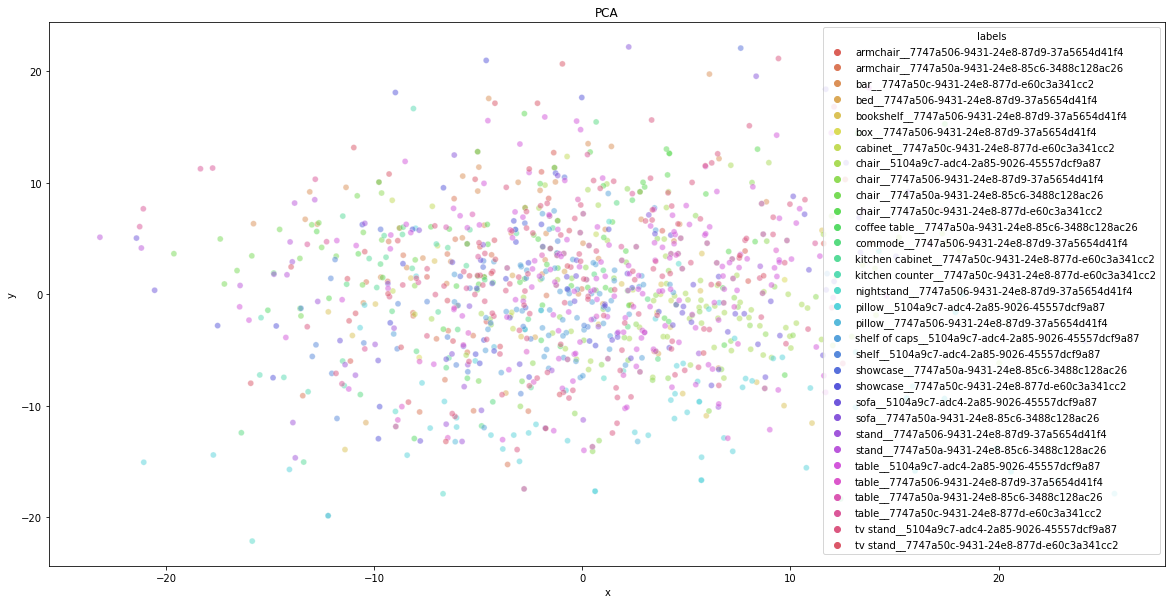

In [140]:
plt.figure(figsize=(20,10))
sns.scatterplot(
    x="x", y="y",
    hue="labels",
    palette=sns.color_palette("hls", nb_labels),
    data=pca_df,
    legend="full",
    alpha=0.5
)
plt.title('PCA')
plt.show()

## t-SNE

In [141]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto',init='random')

In [142]:
tsne_results = tsne.fit_transform(results)

In [143]:
tsne_df = pd.DataFrame()

In [144]:
tsne_df['x'] = tsne_results[:,0]
tsne_df['y'] = tsne_results[:,1]
tsne_df['labels']=labels

In [145]:
tsne_df = tsne_df.sort_values(by=['labels'])

In [146]:
tsne_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129 entries, 689 to 1128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1129 non-null   float32
 1   y       1129 non-null   float32
 2   labels  1129 non-null   object 
dtypes: float32(2), object(1)
memory usage: 26.5+ KB


In [147]:
tsne_df.head()

,x,y,labels
689,-0.321718,28.247864,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
685,-20.673553,6.316301,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
687,-21.421467,6.625892,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
688,-13.353846,12.449696,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
690,16.652025,-20.455017,armchair__7747a506-9431-24e8-87d9-37a5654d41f4


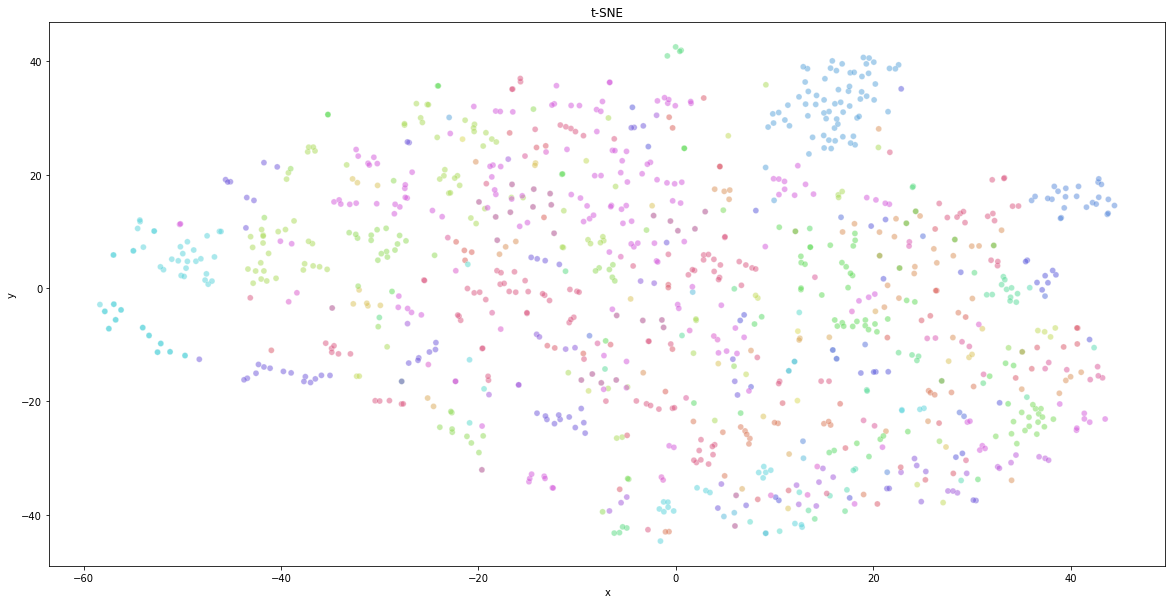

In [148]:
plt.figure(figsize=(20,10))
sns.scatterplot(
    x="x", y="y",
    hue="labels",
    palette=sns.color_palette("hls", nb_labels),
    data=tsne_df,
    legend="full",
    alpha=0.5
)
plt.title('t-SNE')
plt.legend([],[], frameon=False)
plt.show()

## UMAP

In [149]:
import umap.umap_ as umap

In [150]:
reducer = umap.UMAP()

In [151]:
umap_results = reducer.fit_transform(results)

In [152]:
umap_results

array([[8.376986 , 5.9730363],
       [9.432239 , 6.7904873],
       [9.331424 , 3.0113955],
       ...,
       [7.231112 , 8.446446 ],
       [9.236247 , 4.296563 ],
       [9.6565695, 4.527583 ]], dtype=float32)

In [153]:
umap_df = pd.DataFrame()

In [154]:
umap_df['x'] = umap_results[:,0]
umap_df['y'] = umap_results[:,1]
umap_df['labels']=labels

In [155]:
umap_df = umap_df.sort_values(by=['labels'])

In [156]:
umap_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129 entries, 689 to 1128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1129 non-null   float32
 1   y       1129 non-null   float32
 2   labels  1129 non-null   object 
dtypes: float32(2), object(1)
memory usage: 26.5+ KB


In [157]:
umap_df.head()

,x,y,labels
689,10.261531,5.334504,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
685,7.004679,4.588338,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
687,6.933823,4.572622,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
688,8.165661,4.563041,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
690,11.336955,7.240422,armchair__7747a506-9431-24e8-87d9-37a5654d41f4


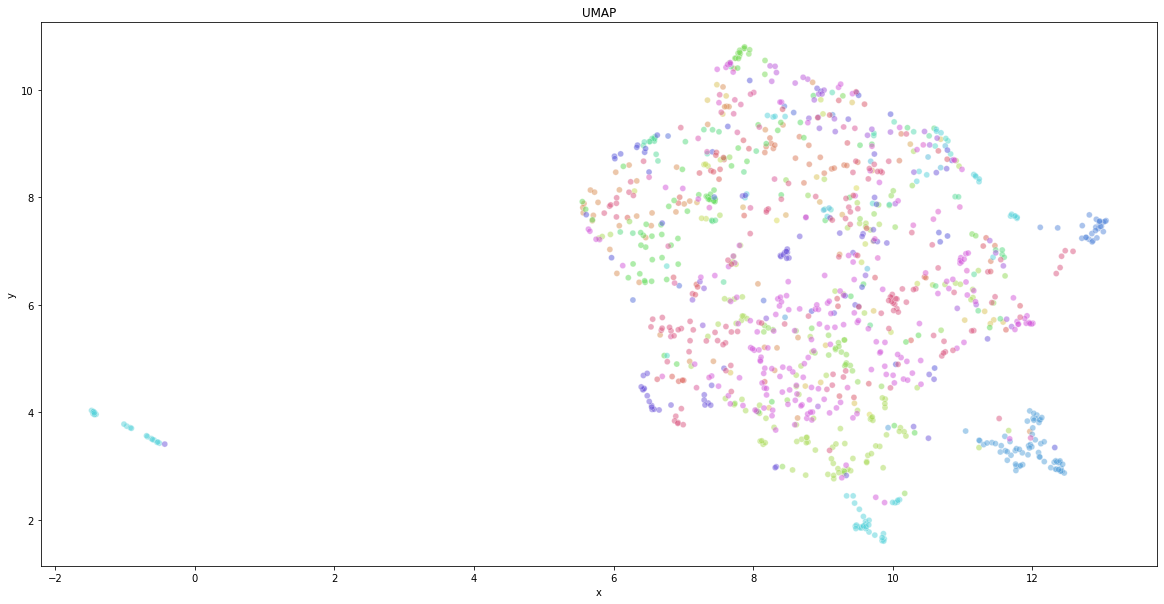

In [158]:
plt.figure(figsize=(20,10))
sns.scatterplot(
    x="x", y="y",
    hue="labels",
    palette=sns.color_palette("hls", nb_labels),
    data=umap_df,
    legend="full",
    alpha=0.5
)
plt.title('UMAP')
plt.legend([],[], frameon=False)
plt.show()

## k Nearest Neighbors

In [159]:
# Reference
ref_labels = []
ref_encodings = []
ref_idx = []
for k, v in tqdm(ref_dict.items()):
    for i in range(len(v)):
        ref_labels.append(k)
        ref_encodings.append(results[v[i]])
        ref_idx.append(v[i])

  0%|          | 0/32 [00:00<?, ?it/s]

In [160]:
# Test
test_labels = []
test_encodings = []
test_idx = []
for k, v in tqdm(test_dict.items()):
    for i in range(len(v)):
        test_labels.append(k)
        test_encodings.append(results[v[i]])
        test_idx.append(v[i])

  0%|          | 0/32 [00:00<?, ?it/s]

In [161]:
len(ref_encodings), len(test_encodings)

(113, 1016)

In [162]:
from sklearn.neighbors import KNeighborsClassifier

In [163]:
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(ref_encodings, ref_labels)
    score = knn.score(test_encodings, test_labels)
    print("For " + str(i) + " neighbors, score of " + str(score))

For 1 neighbors, score of 0.4419291338582677
For 2 neighbors, score of 0.34153543307086615
For 3 neighbors, score of 0.34744094488188976
For 4 neighbors, score of 0.3543307086614173
For 5 neighbors, score of 0.3513779527559055
For 6 neighbors, score of 0.3513779527559055
For 7 neighbors, score of 0.3346456692913386
For 8 neighbors, score of 0.3198818897637795
For 9 neighbors, score of 0.31299212598425197


## Testing on a random query

In [164]:
query_idx = random.randint(0, len(test_idx))
query_instance_idx = test_idx[query_idx]
query_encoding = test_encodings[query_idx]
query_label = test_labels[query_idx]
query_instance_idx

425

In [165]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2, radius=0.4)
neigh.fit(ref_encodings)

NearestNeighbors(n_neighbors=2, radius=0.4)

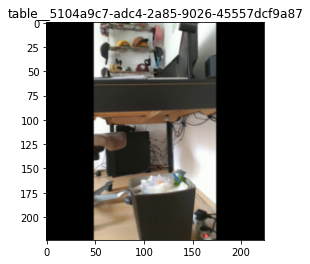

In [166]:
my_loaded_instance = load_instance(instances[query_instance_idx], transform)
plt.imshow(my_loaded_instance["image"].permute(1,2,0).numpy())
plt.title(query_label)
plt.show()

In [167]:
result = neigh.kneighbors([query_encoding], 2, return_distance=False)
result

array([[ 8, 15]])

In [168]:
result_instance_idx = ref_idx[result[0][0]]
result_label = ref_labels[result[0][0]]
result_instance_idx

19

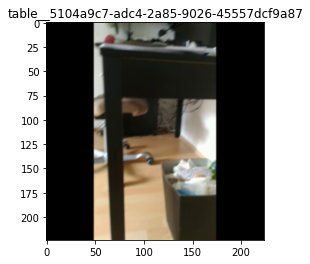

In [169]:
my_loaded_instance = load_instance(instances[ref_idx[result[0][0]]], transform)
plt.imshow(my_loaded_instance["image"].permute(1,2,0).numpy())
plt.title(result_label)
plt.show()

## Manual score

In [170]:
len(ref_labels), len(ref_encodings)

(113, 113)

In [171]:
def reid_score(k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(ref_encodings)
    score = 0
    for i in range(len(test_encodings)):
        query_label = test_labels[i]
        query_encoding = test_encodings[i]
        results = neigh.kneighbors([query_encoding], k, return_distance=False)
        matches_idx = results[0]
        for j in matches_idx:
            match_label = ref_labels[j]
            if match_label == query_label:
                score += 1
                break
    score /= len(test_encodings)
    return score

In [172]:
for i in [1, 2, 5, 10, 20, 50]:
    print(f"rank({i}) = {reid_score(i)}")

rank(1) = 0.4419291338582677
rank(2) = 0.5561023622047244
rank(5) = 0.6919291338582677
rank(10) = 0.7618110236220472
rank(20) = 0.8415354330708661
rank(50) = 0.9478346456692913


In [173]:
def map(k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(ref_encodings)
    mapk = 0
    for i in range(len(test_encodings)):
        query_label = test_labels[i]
        query_encoding = test_encodings[i]
        apk = 0
        results = neigh.kneighbors([query_encoding], k, return_distance=False)
        matches_idx = results[0]
        nb_true_matches = 0
        for idj, j in enumerate(matches_idx):
            if ref_labels[j] == query_label:
                nb_true_matches += 1
                apk += nb_true_matches / (idj+1)
        if nb_true_matches != 0:
            apk /= nb_true_matches
        mapk += apk
    mapk /= len(test_encodings)
    return mapk

In [174]:
for i in [1, 2, 5, 10, 20, 50]:
    print(f"mAP({i}) = {map(i)}")

mAP(1) = 0.4419291338582677
mAP(2) = 0.49901574803149606
mAP(5) = 0.5067790354330696
mAP(10) = 0.4717857961207227
mAP(20) = 0.4187679143787169
mAP(50) = 0.3446942491739481


### Rank 1 2 5 10 20 50

#### BoundingBoxEncoder(use_rmac_layer=True, resize_shape=None)
 
(0.5452755905511811,
 0.6279527559055118,
 0.7372047244094488,
 0.8218503937007874,
 0.8779527559055118,
 0.9399606299212598)
 
### mAP 1 2 5 10 20 50

#### BoundingBoxEncoder(use_rmac_layer=True, resize_shape=None)

(0.5452755905511811,
 0.5866141732283464,
 0.5909517169728791,
 0.5504119583638358,
 0.48468139382767633,
 0.3954481738629733)

<table><tr><th> k <th><th> 1 <th><th> 2 <th><th> 5 <th><th> 10 <th><th> 20 <th><th> 50 <th><tr>
<tr><td> Rank k <td><td> 54.53%  <td><td> 62.79% <td><td> 73.72% <td><td> 82.18% <td><td> 87.79% <td><td> 93.99% <td><tr>
<table>
    
<table><tr><th> k <th><th> 1 <th><th> 2 <th><th> 5 <th><th> 10 <th><th> 20 <th><th> 50 <th><tr>
<tr><td> mAP <td><td> 54.52%  <td><td> 58.66% <td><td> 59.09% <td><td> 55.04% <td><td> 48.47% <td><td> 39.54% <td><tr>
<table>

<table><tr><th> k <th><th> 1 <th><th> 2 <th><th> 5 <th><th> 10 <th><th> 20 <th><th> 50 <th><tr>
<tr><td> mAP <td><td> 44.19%  <td><td> 49.90% <td><td> 50.68% <td><td> 47.18% <td><td> 41.88% <td><td> 34.47% <td><td>
<table>

#### reobj_model = REObjEncoder(requires_grad=False)

rank(1) = 0.4419291338582677
rank(2) = 0.5561023622047244
rank(5) = 0.6919291338582677
rank(10) = 0.7618110236220472
rank(20) = 0.8415354330708661
rank(50) = 0.9478346456692913

mAP(1) = 0.4419291338582677
mAP(2) = 0.49901574803149606
mAP(5) = 0.5067790354330696
mAP(10) = 0.4717857961207227
mAP(20) = 0.4187679143787169
mAP(50) = 0.3446942491739481